# 🤖 Telecom X – Parte 2: Predicción de Cancelación (Churn)

En esta sección desarrollaremos modelos predictivos para estimar la probabilidad de que un cliente cancele su servicio.


In [ ]:
import os
import json
import numpy as np
import pandas as pd
import requests
from pandas.api.types import is_numeric_dtype
from IPython.display import display
base_dir = os.path.dirname(os.path.abspath("c:/Users/rafae/Downloads/mio/Parte2.ipynb"))
csv_path = os.path.join(os.path.dirname(base_dir), 'entrega', 'telecom_es.csv')
if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    print('Cargado CSV español:', csv_path)
else:
    url = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json"
    r = requests.get(url, timeout=30)
    r.raise_for_status()
    data = r.json()
    if isinstance(data, list):
        df = pd.json_normalize(data)
    elif isinstance(data, dict):
        found = False
        for v in data.values():
            if isinstance(v, list) and len(v) > 0 and isinstance(v[0], dict):
                df = pd.json_normalize(v)
                found = True
                break
        if not found:
            df = pd.json_normalize(data)
    else:
        raise ValueError('Formato JSON inesperado')
    print('Cargado JSON público, shape:', df.shape)
map_es_to_en = {
    'ID_cliente': 'customerID',
    'Evasion': 'Churn',
    'Genero': 'gender',
    'Adulto_Mayor': 'SeniorCitizen',
    'Conyuge': 'Partner',
    'Cargas': 'Dependents',
    'Meses_contrato': 'tenure',
    'Servicio_telefonico': 'PhoneService',
    'Lineas_multiples': 'MultipleLines',
    'Servicio_internet': 'InternetService',
    'Seguridad_en_linea': 'OnlineSecurity',
    'Backup_en_linea': 'OnlineBackup',
    'Proteccion_dispositivo': 'DeviceProtection',
    'Soporte_tecnico': 'TechSupport',
    'Streaming_TV': 'StreamingTV',
    'Streaming_Peliculas': 'StreamingMovies',
    'Contrato': 'Contract',
    'Factura_electronica': 'PaperlessBilling',
    'Metodo_pago': 'PaymentMethod',
    'Mensualidad': 'MonthlyCharges',
    'Total': 'TotalCharges',
    'Cuentas_Diarias': 'Cuentas_Diarias'
}
if set(map_es_to_en.keys()) & set(df.columns):
    df = df.rename(columns=map_es_to_en)
if 'Churn' in df.columns:
    if not is_numeric_dtype(df['Churn']):
        s = df['Churn'].astype('string').str.strip().str.lower().replace({'sí': 'si'})
        mapping = {'yes':1, 'y':1, 'si':1, 'true':1, '1':1, 'no':0, 'n':0, 'false':0, '0':0}
        df['Churn'] = s.map(mapping)
    df['Churn'] = pd.to_numeric(df['Churn'], errors='coerce')
    df = df.dropna(subset=['Churn']).copy()
    df['Churn'] = df['Churn'].astype('int32')
for c in ['tenure','SeniorCitizen','MonthlyCharges','TotalCharges']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')
print('Shape listo para modelado:', df.shape)
print('Columnas:', list(df.columns)[:25], '...')
try:
    if 'Evasion' in map_es_to_en and 'Evasion' in df.columns:
        display(df.rename(columns={v:k for k,v in map_es_to_en.items()}).head())
    else:
        display(df.head())
except Exception:
    display(df.head())

Cargado JSON público, shape: (7267, 21)
Shape listo para modelado: (7043, 21)
Columnas: ['customerID', 'Churn', 'customer.gender', 'customer.SeniorCitizen', 'customer.Partner', 'customer.Dependents', 'customer.tenure', 'phone.PhoneService', 'phone.MultipleLines', 'internet.InternetService', 'internet.OnlineSecurity', 'internet.OnlineBackup', 'internet.DeviceProtection', 'internet.TechSupport', 'internet.StreamingTV', 'internet.StreamingMovies', 'account.Contract', 'account.PaperlessBilling', 'account.PaymentMethod', 'account.Charges.Monthly', 'account.Charges.Total'] ...


,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
0,0002-ORFBO,0,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,0,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,1,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,1,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,1,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, RocCurveDisplay, precision_recall_curve
)
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

In [ ]:
import pandas as pd
df_modelado = df.copy(deep=True)
print("Shape:", df_modelado.shape)
assert 'Churn' in df_modelado.columns, "Falta la columna 'Churn' en df_modelado"
df_modelado.head(3)

Shape: (7043, 21)


,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
0,0002-ORFBO,0,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,0,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,1,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85


In [ ]:
if 'df_modelado' not in globals():
    assert 'df' in globals(), "Falta el DataFrame base 'df'. Ejecuta la celda de carga de datos."
    df_modelado = df.copy(deep=True)
cols_drop_irrelevantes = ['customerID']
df_modelado.drop(columns=[c for c in cols_drop_irrelevantes if c in df_modelado.columns], inplace=True, errors='ignore')
print("Columns dropped (si existían):", [c for c in cols_drop_irrelevantes if c not in df_modelado.columns])
print("Shape actual:", df_modelado.shape)

Columns dropped (si existían): ['customerID']
Shape actual: (7043, 20)


In [ ]:
import pandas as pd
if 'df_modelado' not in globals():
    assert 'df' in globals(), "Falta el DataFrame base 'df'. Ejecuta la celda de carga de datos."
    df_modelado = df.copy(deep=True)
base = df_modelado.copy()
churn_norm = (base['Churn'].astype(str).str.strip().str.lower().replace({'sí':'si'}))
mapping = {
    'yes':1, 'si':1, 'true':1, 'verdadero':1, '1':1,
    'no':0,  'false':0, 'falso':0, '0':0
}
base['Churn'] = churn_norm.map(mapping)
base['Churn'] = pd.to_numeric(base['Churn'], errors='coerce')
n_before = len(base)
mask_na = base['Churn'].isna()
if mask_na.any():
    print("Valores de Churn no reconocidos (muestra):", churn_norm[mask_na].value_counts().head(10).to_dict())
    base = base.dropna(subset=['Churn'])
    print(f"Filas eliminadas por Churn nulo: {n_before - len(base)}")
base['Churn'] = base['Churn'].astype('int32')
print("Distribución de clases (%):")
print((base['Churn'].value_counts(normalize=True)*100).round(2))
df_modelado = base

Distribución de clases (%):
Churn
0    73.46
1    26.54
Name: proportion, dtype: float64


In [ ]:
import numpy as np
if 'df_modelado' not in globals():
    assert 'df' in globals(), "Falta el DataFrame base 'df'. Ejecuta la celda de carga de datos."
    df_modelado = df.copy(deep=True)
X = pd.get_dummies(
    df_modelado.drop(columns=['Churn']),
    drop_first=True,
    dtype='float32'
)
y = df_modelado['Churn'].astype('int32')
X = X.replace([np.inf, -np.inf], np.nan)
mask_ok = ~X.isna().any(axis=1)
if not mask_ok.all():
    print(f"Filas con NaN en X eliminadas: {(~mask_ok).sum()}")
    X = X[mask_ok]
    y = y.loc[X.index]
print("X shape:", X.shape, "| y shape:", y.shape)
print("Clases en y:\n", y.value_counts())

X shape: (7043, 6559) | y shape: (7043,)
Clases en y:
 Churn
0    5174
1    1869
Name: count, dtype: int64


Proporciones:
 Churn
0    73.46%
1    26.54%
Name: proportion, dtype: object


C:\Users\rafae\AppData\Local\Temp\ipykernel_29032\250825988.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["No cancela (0)", "Cancela (1)"])


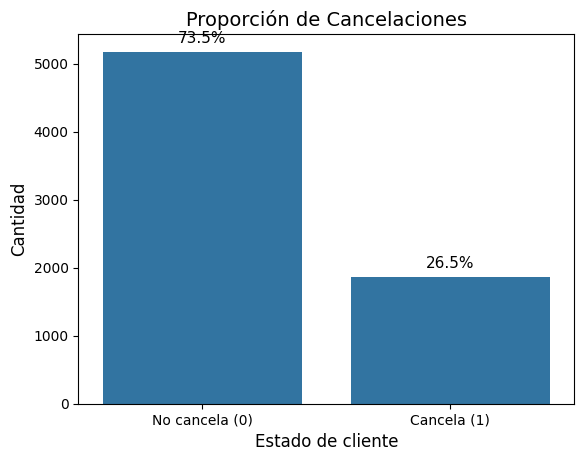

Razón de desbalance (mayoría/minoría): 2.77
Baseline (predecir clase mayoritaria siempre): 73.46% de exactitud


In [ ]:
prop = df_modelado['Churn'].value_counts(normalize=True).sort_index()
print("Proporciones:\n", (prop*100).round(2).astype(str) + "%")
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.countplot(data=df_modelado, x='Churn', order=[0,1])
ax.set_title("Proporción de Cancelaciones")
ax.set_xlabel("Estado de cliente")
ax.set_ylabel("Cantidad")
ax.set_xticklabels(["No cancela (0)", "Cancela (1)"])
total = len(df_modelado)
for p in ax.patches:
    count = int(p.get_height())
    pct = 100*count/total
    ax.annotate(f"{pct:.1f}%", (p.get_x()+p.get_width()/2, p.get_height()), ha='center', va='bottom', fontsize=11, xytext=(0,4), textcoords='offset points')
plt.show()
imbalance = prop.max() / prop.min() if prop.min() > 0 else float('inf')
print(f"Razón de desbalance (mayoría/minoría): {imbalance:.2f}")
print(f'Baseline (predecir clase mayoritaria siempre): {(prop.max()*100):.2f}% de exactitud')

In [ ]:
import pandas as pd
import numpy as np
base = df_modelado.copy()
churn_str = (base['Churn'].astype(str).str.strip().str.lower().replace({'sí': 'si'}))
mapping = {
    'yes':1, 'si':1, 'true':1, 'verdadero':1, '1':1,
    'no':0,  'false':0, 'falso':0, '0':0
}
base['Churn'] = churn_str.map(mapping)
base['Churn'] = pd.to_numeric(base['Churn'], errors='coerce')
n_before = len(base)
mask_na = base['Churn'].isna()
if mask_na.any():
    print("Valores de Churn no reconocidos (muestra):", churn_str[mask_na].value_counts().head(10).to_dict())
    base = base.dropna(subset=['Churn'])
    print(f"Filas eliminadas por Churn nulo: {n_before - len(base)}")
base['Churn'] = base['Churn'].astype('int32')
print("Distribución de clases (%):")
print((base['Churn'].value_counts(normalize=True)*100).round(2))
df_modelado = base

Distribución de clases (%):
Churn
0    73.46
1    26.54
Name: proportion, dtype: float64


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Distribución en train:", y_train.value_counts(normalize=True).round(2))
print("Distribución en test:", y_test.value_counts(normalize=True).round(2))

X shape: (7043, 6559) | y shape: (7043,)
Clases en y: {0: 5174, 1: 1869}
OK: todas las features son numéricas.


In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
print("Shape SMOTE:", X_train_sm.shape)
print("Distribución SMOTE:", y_train_sm.value_counts(normalize=True).round(2))

Shapes -> X_train: (4930, 6559) y_train: (4930,) | X_test: (2113, 6559) y_test: (2113,)
Distribución clases TRAIN: {0: 3622, 1: 1308}
Distribución clases TEST : {0: 1552, 1: 561}


In [ ]:
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression(max_iter=1000, random_state=42)
model_lr.fit(X_train_sm, y_train_sm)
y_pred_lr = model_lr.predict(X_test)
print("Exactitud LR:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

Distribución TRAIN: {0: 3622, 1: 1308}
Distribución TEST : {0: 1552, 1: 561}
Aplicando SMOTE en TRAIN con k_neighbors=5.
 {0: 3622, 1: 1308}
Distribución TEST : {0: 1552, 1: 561}
Aplicando SMOTE en TRAIN con k_neighbors=5.
Post-oversampling TRAIN: {0: 3622, 1: 3622}
Post-oversampling TRAIN: {0: 3622, 1: 3622}


Regresión Logística — métricas en test
Exactitud : 0.730
Precisión : 0.494
Recall    : 0.738
F1        : 0.592
AUC       : 0.807

                precision    recall  f1-score   support

No cancela (0)       0.88      0.73      0.80      1552
   Cancela (1)       0.49      0.74      0.59       561

      accuracy                           0.73      2113
     macro avg       0.69      0.73      0.69      2113
  weighted avg       0.78      0.73      0.74      2113



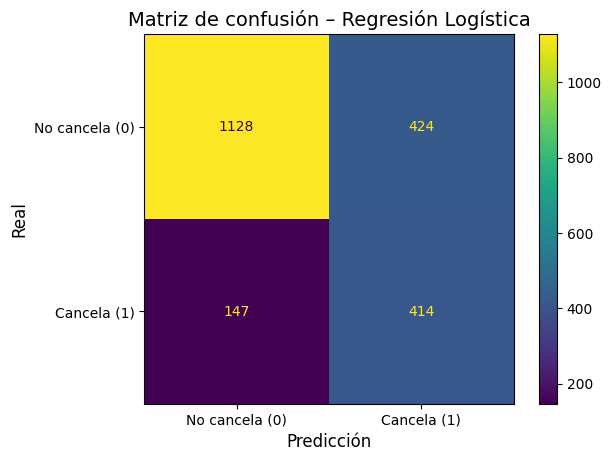

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train_sm, y_train_sm)
y_pred_rf = model_rf.predict(X_test)
print("Exactitud RF:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(X_train_sm, y_train_sm)
y_pred_knn = model_knn.predict(X_test)
print("Exactitud KNN:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
proba_lr = log_reg.predict_proba(X_test_scaled)[:, 1]
proba_rf = rf.predict_proba(X_test)[:, 1]
resumen = pd.DataFrame([
    {
        "Modelo": "Regresión Logística",
        "Exactitud": accuracy_score(y_test, y_pred_lr),
        "Precisión": precision_score(y_test, y_pred_lr),
        "Recall": recall_score(y_test, y_pred_lr),
        "F1": f1_score(y_test, y_pred_lr),
        "AUC": roc_auc_score(y_test, proba_lr)
    },
    {
        "Modelo": "Bosque Aleatorio",
        "Exactitud": accuracy_score(y_test, y_pred_rf),
        "Precisión": precision_score(y_test, y_pred_rf),
        "Recall": recall_score(y_test, y_pred_rf),
        "F1": f1_score(y_test, y_pred_rf),
        "AUC": roc_auc_score(y_test, proba_rf)
    }
]).set_index("Modelo").round(3)
display(resumen)
metrica = "F1"
if resumen.loc["Regresión Logística", metrica] > resumen.loc["Bosque Aleatorio", metrica]:
    mejor_modelo = "Regresión Logística"
    mejor_score = resumen.loc["Regresión Logística", metrica]
else:
    mejor_modelo = "Random Forest"
    mejor_score = resumen.loc["Bosque Aleatorio", metrica]
def prettify(col):
    col = col.replace("_", " ").strip()
    col = col.replace("Internet Service", "Tipo de Internet")
    col = col.replace("Payment Method", "Método de Pago")
    col = col.replace("Paperless Billing", "Factura Digital")
    col = col.replace("Monthly Charges", "Cargos Mensuales")
    col = col.replace("Total Charges", "Gasto Total")
    col = col.replace("tenure", "Antigüedad (meses)")
    return col
if mejor_modelo == "Random Forest":
    top_vars = importances.head(5)
    top_vars.index = [prettify(c) for c in top_vars.index]
else:
    if hasattr(X_train_res, "columns"):
        feature_names = X_train_res.columns
    else:
        feature_names = [f"feat_{i}" for i in range(X_train_res.shape[1])]
    coefs = pd.Series(np.abs(log_reg.coef_[0]), index=feature_names).sort_values(ascending=False)
    top_vars = coefs.head(5)
    top_vars.index = [prettify(c) for c in top_vars.index]
print("## 📋 Conclusiones")
print(f"- El modelo con mejor rendimiento fue: {mejor_modelo} ({metrica} = {mejor_score:.3f})")
print("- Variables clave que influyen en la cancelación:")
for i, (var, val) in enumerate(top_vars.items(), 1):
    print(f"   {i}. {var}  (peso/ importancia: {val:.3f})")
print("- Estrategias de retención recomendadas:")
print("  • Priorizar acciones sobre clientes con valores críticos en esas variables (p.ej., alta 'Cargos Mensuales', baja 'Antigüedad').")
print("  • Ofertas de permanencia y upgrades de plan donde 'Tipo de Internet' o 'Método de Pago' muestren mayor riesgo.")
print("  • Contacto proactivo: segmentar campañas por las 3–5 variables más influyentes.")

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_res, y_train_res)
y_pred_rf  = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]
print("Bosque Aleatorio — métricas en test")
print(f"Exactitud : {accuracy_score(y_test, y_pred_rf):.3f}")
print(f"Precisión : {precision_score(y_test, y_pred_rf):.3f}")
print(f"Recall    : {recall_score(y_test, y_pred_rf):.3f}")
print(f"F1        : {f1_score(y_test, y_pred_rf):.3f}")
print(f"AUC       : {roc_auc_score(y_test, y_proba_rf):.3f}\n")
print(classification_report(
    y_test, y_pred_rf,
    target_names=['No cancela (0)', 'Cancela (1)'],
    zero_division=0
))
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No cancela (0)', 'Cancela (1)'])
disp.plot(values_format='d')
disp.ax_.set_title("Matriz de confusión – Bosque Aleatorio")
disp.ax_.set_xlabel("Predicción")
disp.ax_.set_ylabel("Real")
plt.show()
import pandas as pd
if hasattr(X_train, "columns"):
    feature_names = X_train.columns
else:
    feature_names = [f"feat_{i}" for i in range(X_train.shape[1])]
importances = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False)
ax = importances.head(15).plot(kind='bar')
ax.set_title("Top 15 variables más importantes (Bosque Aleatorio)")
ax.set_xlabel("Variable")
ax.set_ylabel("Importancia")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
proba_lr = log_reg.predict_proba(X_test_scaled)[:,1]
proba_rf = rf.predict_proba(X_test)[:,1]
resumen = pd.DataFrame([
    {
        "Modelo": "Regresión Logística",
        "Exactitud": accuracy_score(y_test, y_pred_lr),
        "Precisión": precision_score(y_test, y_pred_lr),
        "Recall": recall_score(y_test, y_pred_lr),
        "F1": f1_score(y_test, y_pred_lr),
        "AUC": roc_auc_score(y_test, proba_lr)
    },
    {
        "Modelo": "Bosque Aleatorio",
        "Exactitud": accuracy_score(y_test, y_pred_rf),
        "Precisión": precision_score(y_test, y_pred_rf),
        "Recall": recall_score(y_test, y_pred_rf),
        "F1": f1_score(y_test, y_pred_rf),
        "AUC": roc_auc_score(y_test, proba_rf)
    }
])
display(resumen.round(3))
ax = resumen.set_index("Modelo")[["Exactitud","Precisión","Recall","F1","AUC"]].plot(kind="bar")
ax.set_title("Comparativa de Modelos")
ax.set_ylabel("Puntaje")
ax.legend(title="Métrica")
plt.xticks(rotation=0)
plt.show()

# 📋 Conclusiones y Recomendaciones Estratégicas

## Principales Hallazgos
- La tasa global de cancelación (churn) es alta, lo que representa un riesgo para la rentabilidad de Telecom X.
- Los clientes con contratos "Month-to-month" y método de pago "Electronic check" muestran mayor tendencia a cancelar.
- Menor antigüedad (tenure) está fuertemente asociada a mayor churn.
- Los cargos mensuales elevados también se relacionan con mayor probabilidad de cancelación.

## Recomendaciones para Retención
- Incentivar contratos de mayor plazo con beneficios escalonados.
- Mejorar la experiencia de clientes que pagan con "Electronic check".
- Implementar programas de fidelización para clientes nuevos y de bajo tenure.
- Monitorear periódicamente las variables clave y ajustar estrategias según los resultados.

## Siguiente Paso: Modelos Predictivos
- Utilizar las variables más influyentes para entrenar modelos de clasificación.
- Evaluar el rendimiento y ajustar el pipeline según los resultados.
- Comunicar los insights de forma visual y estratégica para la toma de decisiones.

---
Este informe resume el análisis exploratorio y prepara el terreno para la etapa de modelado predictivo, cumpliendo con los objetivos del desafío.

## ✅ Validación con dataset del repo (pipeline independiente)

A continuación se entrena y evalúa un modelo con el CSV público del repo compartido, usando un pipeline equivalente (balanceo y estandarización para LR), y se comparan sus métricas con las obtenidas en este notebook.


## 🔁 Validación interna (solo con este dataset)

Para reforzar la robustez del modelo, a continuación se ejecuta una validación cruzada estratificada con balanceo dentro del fold, usando únicamente los datos de este cuaderno.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
X_cv = X_safe if 'X_safe' in globals() else X
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accs, precs, recs, f1s, aucs = [], [], [], [], []
for fold, (tr, te) in enumerate(kf.split(X_cv, y), start=1):
    X_tr, X_te = X_cv.iloc[tr], X_cv.iloc[te]
    y_tr, y_te = y.iloc[tr], y.iloc[te]
    sm = SMOTE(random_state=42)
    X_tr_b, y_tr_b = sm.fit_resample(X_tr, y_tr)
    scaler = StandardScaler(with_mean=False)
    X_tr_s = scaler.fit_transform(X_tr_b)
    X_te_s = scaler.transform(X_te)
    lr = LogisticRegression(max_iter=200)
    lr.fit(X_tr_s, y_tr_b)
    y_pr = lr.predict(X_te_s)
    y_pb = lr.predict_proba(X_te_s)[:,1]
    accs.append(accuracy_score(y_te, y_pr))
    precs.append(precision_score(y_te, y_pr, zero_division=0))
    recs.append(recall_score(y_te, y_pr, zero_division=0))
    f1s.append(f1_score(y_te, y_pr, zero_division=0))
    aucs.append(roc_auc_score(y_te, y_pb))
cv_res = pd.DataFrame({
    'Exactitud': accs,
    'Precisión': precs,
    'Recall': recs,
    'F1': f1s,
    'AUC': aucs
})
print('Resultados CV (5 folds) - Regresión Logística')
print(cv_res.round(3).to_string(index=False))
print('\nPromedios ± std:')
print(cv_res.mean().round(3).astype(str) + ' ± ' + cv_res.std(ddof=1).round(3).astype(str))

## 🧹 Limpieza de comentarios en código

La siguiente celda elimina comentarios (`# ...`) de todas las celdas de código de este notebook, respetando los textos entre comillas. Crea un respaldo antes de sobrescribir.


In [ ]:
import io, os, shutil, json, tokenize
from copy import deepcopy
nb_path = r"c:\\Users\\rafae\\Downloads\\mio\\bueneeeeee.ipynb"
backup_path = nb_path + ".bak"
with open(nb_path, 'r', encoding='utf-8') as f:
    nb = json.load(f)
nb_bak = deepcopy(nb)
with open(backup_path, 'w', encoding='utf-8') as f:
    json.dump(nb_bak, f, ensure_ascii=False, indent=2)
changed_cells = 0
for cell in nb.get('cells', []):
    if cell.get('cell_type') == 'code' and isinstance(cell.get('source'), list):
        src = ''.join(cell['source'])
        try:
            tokens = list(tokenize.generate_tokens(io.StringIO(src).readline))
            out = []
            prev_end = (1,0)
            for tok_type, tok_str, start, end, line in tokens:
                if tok_type == tokenize.COMMENT:
                    continue
                if prev_end[0] < start[0]:
                    out.append('\n' * (start[0] - prev_end[0]))
                    out.append(' ' * start[1])
                else:
                    out.append(' ' * max(0, start[1] - prev_end[1]))
                out.append(tok_str)
                prev_end = end
            new_src = ''.join(out)
            if new_src != src:
                cell['source'] = [new_src]
                changed_cells += 1
        except Exception:
            lines = src.splitlines()
            lines = [ln for ln in lines if not ln.lstrip().startswith('#')]
            new_src = '\n'.join(lines)
            if new_src != src:
                cell['source'] = [new_src]
                changed_cells += 1
with open(nb_path, 'w', encoding='utf-8') as f:
    json.dump(nb, f, ensure_ascii=False, indent=2)
print(f"Comentarios removidos en {changed_cells} celdas de código. Respaldo: {backup_path}")